In [42]:
import zipfile
from subprocess import call

import psutil

import pandas as pd
import numpy as np
import json
import datetime

import os
import cPickle as pickle
from multiprocessing import Pool

import geopy
import geopandas as gpd
import shapely.geometry as geom

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.max_columns = 55

In [ ]:
base_url = "https://s3.amazonaws.com/tripdata/"
for d in range(201501,201513):
    url = base_url + str(d) + '-citibike-tripdata.zip'
    print(url)
    call(['wget',url])
    zfile = zipfile.ZipFile(str(d)+'-citibike-tripdata.zip', 'r' )
    zfile.extractall('unzippedData/')
    zfile.close()

In [3]:
# LOAD INTO PANDAS
dfs = []
for f in os.listdir('unzippedData/'):
    dfs.append(pd.read_csv('unzippedData/'+f))
    
full_df = pd.concat(dfs, ignore_index=True)

In [4]:
print(full_df.shape)

print(full_df.columns)

full_df.head(8)

(9937969, 15)
Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1
5,496,1/1/2015 0:07,1/1/2015 0:15,512,W 29 St & 9 Ave,40.750073,-73.998393,383,Greenwich Ave & Charles St,40.735238,-74.000271,20788,Subscriber,1969.0,2
6,152,1/1/2015 0:07,1/1/2015 0:09,498,Broadway & W 32 St,40.748549,-73.988084,474,5 Ave & E 29 St,40.745168,-73.986831,19006,Subscriber,1972.0,1
7,1183,1/1/2015 0:08,1/1/2015 0:28,405,Washington St & Gansevoort St,40.739323,-74.008119,174,E 25 St & 1 Ave,40.738177,-73.977387,17640,Subscriber,1985.0,2


### Cleaning the Data

In [7]:
# Get rid of rides that are too long
# Citibike is designed for 30 min rides and charges $4 for every 15 min past that.

# only 1% of rides are longer than an hour so we can get rid of them
long_rides = len(full_df.loc[full_df.tripduration > 3600, 'tripduration'])
print(float(long_rides)/len(full_df))

full_df.drop(full_df[full_df.tripduration>3600].index, inplace = True)
assert len(full_df) == total_rides - long_rides

0.01324928665


In [9]:
# Get rid of cancelled rides
# I'm assuming that rides that are under 2 minutes and start and stop at the same station are essentially cancellations.

cancelled = full_df.loc[(full_df.tripduration<120) & (full_df['start station id'] == full_df['end station id'])]
print('Number of Cancelled Rides:', cancelled.shape[0])

full_df.drop(cancelled.index, inplace = True)

assert len(full_df) == total_rides - long_rides - len(cancelled)

('Number of Cancelled Rides:', 29345)


In [10]:
# NAs

# birth Year has 1.2 million nulls
# we will come back to that as the rest looks pretty good.
full_df.isnull().sum() 

tripduration                     0
starttime                        0
stoptime                         0
start station id                 0
start station name               0
start station latitude           0
start station longitude          0
end station id                   0
end station name                 0
end station latitude             0
end station longitude            0
bikeid                           0
usertype                         0
birth year                 1210701
gender                           0
dtype: int64

 ### Trip Data

####  How many rides were there in 2015

In [11]:
total_rides = len(full_df)
print(total_rides)

9776953


####  Evaluating Trip Durations

Plot Trip Durations

The data is too large for my puny macbook air so i'm going to use a sample of it

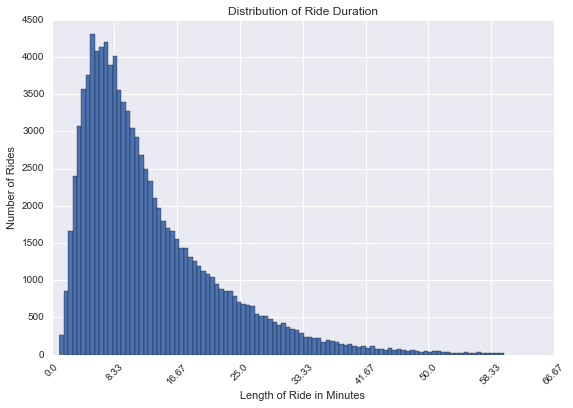

In [13]:
samp = full_df.sample(100000)

plt.figure(figsize=(9,6))
y, x, patches = plt.hist(samp.tripduration, bins = 100)

# get center of bins rather than edges
x = (x[1:] + x[:-1])/2
# normalize y
y = y/y.sum()


ax = plt.gca()
ax.set_xticklabels(np.round(plt.xticks()[0]/60, 2), rotation = 45)
plt.xlabel('Length of Ride in Minutes')
plt.ylabel('Number of Rides')
plt.title('Distribution of Ride Duration')

# BULK OF PEOPLE PROBABLY JUST RIDE TO WORK OR TO FROM NEARBY LOCATION
# AS IS THE DESIGNED USE FOR CITIBIKE

In [14]:
# Find a Distribution
from scipy.stats import pareto, logistic, lognorm, betaprime, beta, f, expon, norm

'''
The process involves fitting a distribution to the sample data
calculating the histogram (true distribution)
calculating the pdf of the fitted theoretical distribution
calculating the mean square error

''';

In [15]:
# use x an y from previous histogram

param_dic = {}
pdf_df = pd.DataFrame({'x':x, 'y':y})

for dist in [betaprime, beta, f]:
    #fit distribution to our data
    params = dist.fit(samp.tripduration) # this returns (*shapes, location, scale) 
                                # can be multiple shape parameters
    
    # pdf takes (x_values, *shape_params, location, scale)
    pdf = dist.pdf(x, *params[:-2], loc = params[-2], scale = params[-1])

    
    # store the parameters and pdf results
    param_dic[dist.name] = params
    pdf_df[dist.name] = pdf

In [16]:
cols = [c for c in pdf_df if c not in ('x','y')]
# calculate Sum of Squared Errors
sse = pdf_df[cols].sub(pdf_df.y, axis = 0).pow(2).sum()

sse.sort_values()

betaprime    0.024399
f            0.024400
beta         0.024449
dtype: float64

('betaprime', 'firebrick')
('beta', 'limegreen')
('f', 'coral')


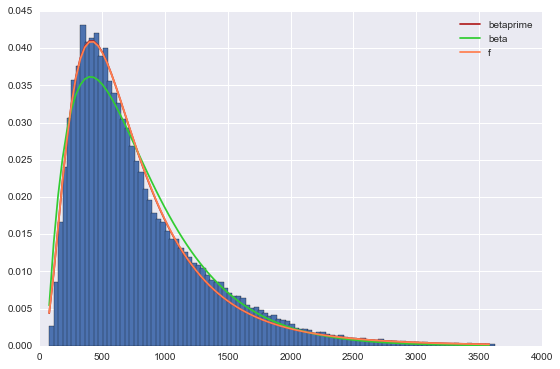

In [17]:
plt.figure(figsize = (9,6))
plt.bar(x,y, width = 44);

colors = ['firebrick','limegreen','coral', (115/255., 44/255., 123/255.)]
c = 0



for col in cols:
    print(col,colors[c])
    norm = y.sum()/pdf_df[col].sum()
    plt.plot(x,pdf_df[col].values*norm, color = colors[c], label = col)
    c+=1

plt.legend()

#### Evaluate Trips by Hour of the Day

In [18]:
samp = full_df.sample(100000)
print(samp.shape)
samp['starttime'] = pd.to_datetime(samp.starttime)
samp['stoptime'] = pd.to_datetime(samp.stoptime)

(100000, 15)


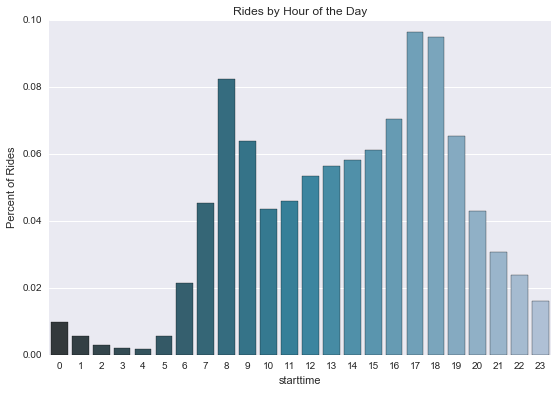

In [19]:
# Group by Hour and Plot
byhour = samp.groupby(samp.starttime.dt.hour)
sns.barplot(byhour.size().index, byhour.size()/byhour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day')

# Most people ride to and from work - morning and eve rush hour (8-9am, 5-6pm)

Examine Weekdays Vs Weekends

In [20]:
# MONDAY = 0, SUNDAY = 6
weekdays = samp[samp.starttime.dt.dayofweek < 5]
weekends = samp[samp.starttime.dt.dayofweek >= 5]


print weekdays.shape[0], weekends.shape[0]

77087 22913


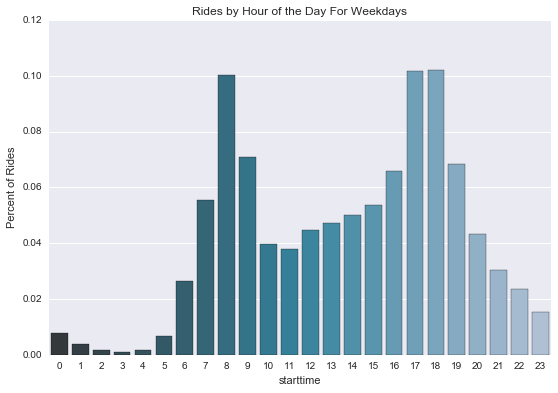

In [21]:
# WEEKDAYS
wdayByHour = weekdays.groupby(weekdays.starttime.dt.hour)
sns.barplot(wdayByHour.size().index, wdayByHour.size()/wdayByHour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day For Weekdays')

# The trend is exaggerated for weekdays 

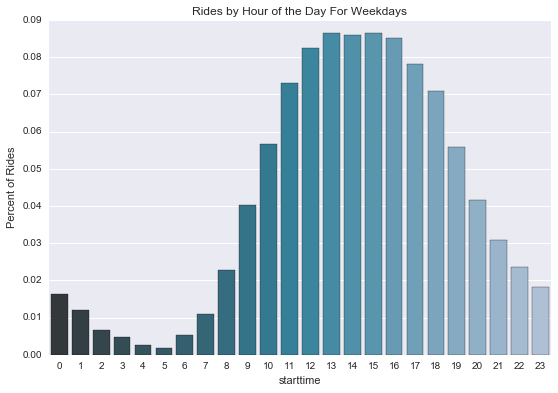

In [23]:
# WEEKENDS
wendByHour = weekends.groupby(weekends.starttime.dt.hour)
sns.barplot(wendByHour.size().index, wendByHour.size()/wendByHour.size().sum(), palette = 'PuBuGn_d')
fig =plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(9)
plt.ylabel('Percent of Rides')
plt.title('Rides by Hour of the Day For Weekdays')

# And inverse for weekends

For the rest of the exploration i'm going to use just the data from January, April, July and October. This is better than random sampling as it has data pertaining to sequential trips and the trips will follow each other in time. I chose these four months as they reprisent the midpoints of each of the 4 seasons of the year.

In [25]:
# converting to datetime objects takes far too long so i'm going to use
# 4 months of data as a sample

# samples can't be random since they would lose the consequitive ride information if they were
# eg most bikes would start in different locations than they "previously" ended

months = full_df.starttime.str.findall(r'(\d+)/\d+/\d+\s')
months= months.map(lambda l: l[0])

month_ixs = months[months.isin(['1','4','7','10'])].index

samp = full_df.ix[month_ixs] 
samp['starttime'] = pd.to_datetime(samp.starttime)
samp['stoptime'] = pd.to_datetime(samp.stoptime)

In [27]:
# save to pickle so I don't have to convert dates again
with open('sample4Months.pkl', 'wb') as f:
    pickle.dump(samp, f, 2)

In [2]:
# Load from pickle
with open('sample4Months.pkl', 'rb') as f:
    samp = pickle.load(f)

In [3]:
#(3184288, 18)
# Parse Date Info
samp['month'] = samp.starttime.dt.month
samp['dow'] = samp.starttime.dt.dayofweek
samp['date'] = samp.starttime.dt.date
samp.shape

(3184288, 18)

#### On average, how many rides per day are there?

In [4]:
print('Avg number of rides per day across all stations:', samp.groupby(samp.starttime.dt.date).size().mean().round(0))

('Avg number of rides per day across all stations:', 25889.0)


#### What's the average usage by day of the week?

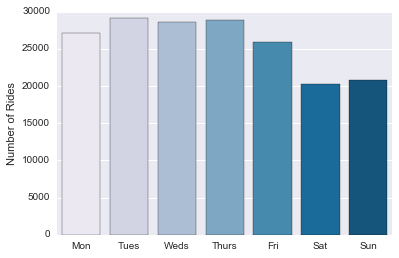

In [5]:
daily_usage = samp.groupby(samp.starttime.dt.date).size().reset_index()
daily_usage['starttime'] = pd.to_datetime(daily_usage.starttime)
daily_usage.columns = ['starttime','Num_Rides']
sns.barplot(daily_usage.groupby(daily_usage.starttime.dt.dayofweek).mean().index.tolist(), daily_usage.groupby(daily_usage.starttime.dt.dayofweek).mean().values[:,0], palette = 'PuBu')
plt.xticks(range(7), ['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'])
plt.ylabel("Number of Rides")

#### What are the busiest stations overall?

In [6]:
# Map station ids to name
stnID_name = samp[['start station id', 'start station name']].drop_duplicates('start station id').sort_values('start station id')
stnID_name.set_index('start station id', inplace=True)

# MOST USED STATIONS
stnID_name.ix[samp.groupby('start station id').size().nlargest(10).index]

busiest_stations = pd.merge(stnID_name.ix[samp.groupby('start station id').size().nlargest(10).index], 
         samp.groupby('start station id').size().sort_values(ascending = False).nlargest(10).reset_index(),
         left_index = True, right_on= 'start station id')

busiest_stations.columns = ['start_station_name','start_station_id','Total_Usage']

# Looks like the busiest stations are in midtown and downtown 
busiest_stations[['start_station_name', 'Total_Usage']].sort_values('Total_Usage', ascending=False)

,start_station_name,Total_Usage
0,8 Ave & W 31 St,32331
1,Pershing Square North,31544
2,Lafayette St & E 8 St,31211
3,W 21 St & 6 Ave,28235
4,E 17 St & Broadway,27528
5,West St & Chambers St,24976
6,Broadway & E 14 St,23890
7,Cleveland Pl & Spring St,22274
8,Greenwich Ave & 8 Ave,21991
9,Broadway & E 22 St,21673


#### Where are most people going?

In [7]:
# Busiest END Stations
stnID_name.ix[samp.groupby('end station id').size().nlargest(10).index]

end_stations = pd.merge(stnID_name.ix[samp.groupby('end station id').size().nlargest(10).index], 
         samp.groupby('end station id').size().sort_values(ascending = False).nlargest(10).reset_index(),
         left_index = True, right_on= 'end station id')

end_stations.columns = ['end_station_name','end_station_id','Total_Usage']

# Pretty much the same except w 41st and 8th
end_stations[['end_station_name', 'Total_Usage']].sort_values('Total_Usage', ascending=False)

,end_station_name,Total_Usage
0,Lafayette St & E 8 St,31176
1,E 17 St & Broadway,29061
2,W 21 St & 6 Ave,28536
3,Pershing Square North,28529
4,8 Ave & W 31 St,27591
5,West St & Chambers St,25901
6,Broadway & E 14 St,24134
7,W 41 St & 8 Ave,23104
8,Greenwich Ave & 8 Ave,22393
9,Cleveland Pl & Spring St,22170


Later I will look at whole trips to see start-end stations of each trip and where people are going from each location. 

### Teleporting Bikes

There are instances where a bike's next trip originates from a different station than it was returned to for its most recent previous trip. What do you think causes this?


In [8]:
# groupby bikeid and sort by time to get sequential rides on each bike
bybike = samp.groupby('bikeid').apply(lambda v: v.sort_values('starttime')).drop('bikeid',axis =1).reset_index(0)

#shift bikeid, end station, and end_times for sequential comparisons
bybike['prev_bikeid'] = bybike.bikeid.shift(1)
# prevent overlapping ids
bybike.loc[bybike.prev_bikeid != bybike.bikeid, 'prev_bikeid'] = np.nan
# same for end station
bybike['prev_end_station_id'] = bybike['end station id'].shift(1)
bybike.loc[bybike.prev_bikeid.isnull(), 'prev_end_station_id'] = np.nan

# same for stoptime
bybike['prev_stoptime'] = bybike.stoptime.shift(1)
bybike.loc[bybike.prev_bikeid.isnull(), 'prev_stoptime'] = np.nan


# now select rows where prev_end_station does not equal start station
mismatch = bybike[(bybike.prev_end_station_id != bybike['start station id']) & (~bybike.prev_bikeid.isnull())]

# about 8% are mismatches
mismatch.shape

(248367, 21)

Explore the Mismatches

Avg Num Mismatches per Bike: 29.773076001


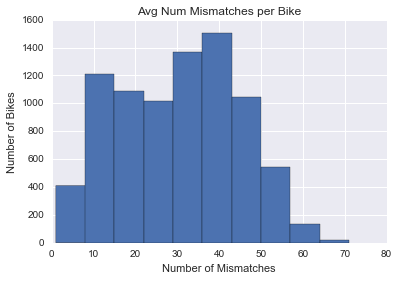

In [9]:
print 'Avg Num Mismatches per Bike:', mismatch.groupby('bikeid').size().mean()

mismatch.groupby('bikeid').size().hist()
plt.title('Avg Num Mismatches per Bike')
plt.xlabel('Number of Mismatches')
plt.ylabel('Number of Bikes')

Mismatches by day of the week and time of day

In [10]:
# MONDAY = 0, SUNDAY = 6
weekdays = mismatch[mismatch.starttime.dt.dayofweek < 5]
weekends = mismatch[mismatch.starttime.dt.dayofweek >= 5]

# ~80% happen during the week implying slight bias to the weekdays. EG 4:1 instead of 5:2
print "Percent of reappearances that happen on a weekday:", np.round(weekdays.shape[0]/float(len(mismatch)),2)


Percent of reappearances that happen on a weekday: 0.81


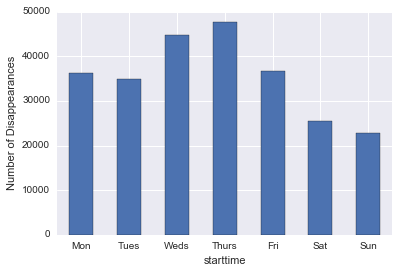

In [11]:
# Confirmed by looking at mismatches by DOW
# Majority of disappearances happen in the middle of the week
ax = mismatch.groupby(mismatch.starttime.dt.dayofweek).size().plot(kind='bar')
ax.set_xticklabels(['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'], rotation = 0)
ax.set_ylabel('Number of Disappearances')

Look at difference in start time and previous end time for mismatches

In [12]:
mismatch['time_diff'] = mismatch.starttime - mismatch.prev_stoptime

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
# Average time between mismatches
print 'Avg bike-disappearance time:',mismatch.time_diff.mean()
# Median time between mismatches
print 'Median bike-disappearance time:',mismatch.time_diff.median()

# I'm taking the median because the mean is dragged up by some very heavy outliers
print
print "Largest time gaps between bike reappearance:"
mismatch.time_diff.nlargest(10)

Avg bike-disappearance time: 5 days 02:17:45.110594
Median bike-disappearance time: 0 days 10:56:37

Largest time gaps between bike reappearance:


6952942   270 days 03:03:33
7530781   258 days 14:58:03
7386253   255 days 11:36:50
6935800   252 days 23:11:28
7003914   245 days 19:03:44
6943393   243 days 16:06:09
6936034   243 days 13:22:15
6934739   242 days 09:33:36
8072347   200 days 13:22:53
7174476   188 days 23:25:50
Name: time_diff, dtype: timedelta64[ns]

Comparing our station-mismatched bikes to the rest of the bikes, 
we see that normally functioning bikes are generally inactive for a much shorter period of time


In [14]:
normal = bybike[~bybike.index.isin(mismatch.index)]
print normal.shape
assert normal.shape[0] + mismatch.shape[0] == bybike.shape[0]
# The average inactivity for normal functioning bikes is about 3 hours
print 'Avg time inactive:',(normal.starttime - normal.prev_stoptime).mean()


# However this is being dragged up by some outliers as well and the median time is actually significantly lower still.
print 'Median time inactive:',(normal.starttime - normal.prev_stoptime).median()


(2935921, 21)
Avg time inactive: 0 days 03:29:11.157549
Median time inactive: 0 days 00:38:23


My conclusion on the matter is that bikes that stop at one station and then "mysteriously" appear at another station are most likely being worked on. The median time a bike is generally inactive for is about 30 minutes, which is much shorter than the median time of 10 hours for bikes that start at a different staion than they last ended. 

### Who's Riding Citibike?

The data comes with 3 features that describe the riders. These are the User Type (Subscriber, vs Customer/Day Pass), Birth Year of the rider, and Gender

However, the birth year is missing a lot of values

In [15]:
print samp[['usertype','birth year', 'gender']].isnull().sum()

# Thes are almost all from Customers with day passes so it makes sense that citibike would not have their birthday
print
print "Missing ages for each user type:"
samp[samp['birth year'].isnull()].usertype.value_counts()

usertype           0
birth year    367724
gender             0
dtype: int64

Missing ages for each user type:


Customer      367717
Subscriber         7
Name: usertype, dtype: int64

#### What's the ratio of subscribers to customers?

In [16]:
print samp.usertype.value_counts()
print
# 88% of rides are by subscribers
print 'Percent of rides by subscribers: ',(samp.usertype.value_counts()['Subscriber']/float(len(samp))).round(2)

Subscriber    2816571
Customer       367717
Name: usertype, dtype: int64

Percent of rides by subscribers:  0.88


Subscriber    2816571
Customer       367717
Name: usertype, dtype: int64


''

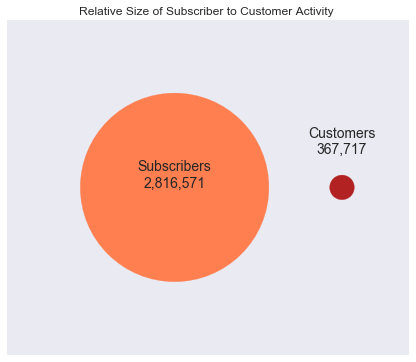

In [17]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from scipy.interpolate import spline

print samp.usertype.value_counts()

plt.figure(figsize=(9,6))
ax = plt.gca()
plt.xlim(0,1200)
plt.ylim(0,1000)
cust = Circle((1000,500),radius=samp.usertype.value_counts()['Customer']/10000., color = 'firebrick')
subs = Circle((500,500), radius = samp.usertype.value_counts()['Subscriber']/10000., color = 'coral')

ax.add_patch(cust)
ax.add_patch(subs)
ax.set_aspect(1)

plt.text(500,500, 'Subscribers\n{:,}'.format(samp.usertype.value_counts()['Subscriber']), ha='center', fontsize=14)

plt.text(1000,600, 'Customers\n{:,}'.format(samp.usertype.value_counts()['Customer']), ha='center', fontsize=14)

plt.xticks([])
plt.yticks([])
plt.title('Relative Size of Subscriber to Customer Activity ')
;

### Exploring Day Pass Customers

In [87]:
custs = samp[samp.usertype=='Customer']
custs.shape

(367717, 18)

Here we can see a pattern emerge in the spring and summer, where non-subscriber usage spikes on the weekends.

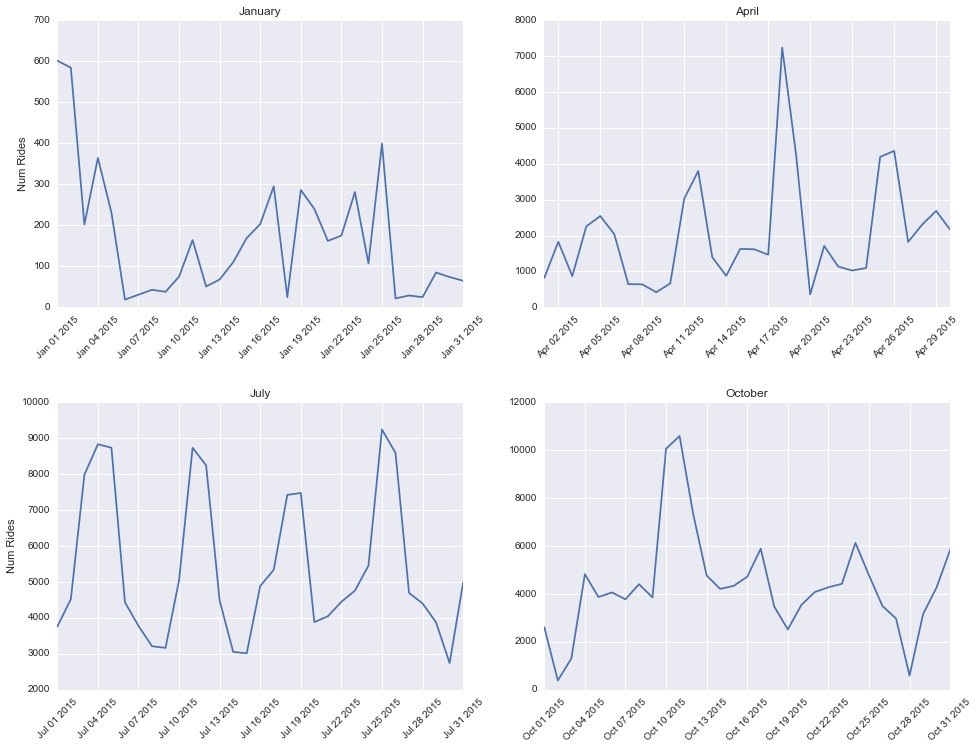

In [19]:
plt.figure(figsize=(16,12))
months = custs.month.unique()
month_names = ['January', 'April', 'July', 'October']
for i in range(len(months)):
    plt.subplot(2,2,i+1)
    month_data = custs[custs.month==months[i]].groupby('date').size()
    month_data.plot()
    plt.xticks(rotation = 45)
    plt.title(month_names[i])
    plt.xlabel('')

    
plt.subplots_adjust(hspace = 0.33)
plt.subplot(2,2,1)
plt.ylabel('Num Rides')
plt.subplot(2,2,3)
plt.ylabel('Num Rides')

([<matplotlib.axis.XTick at 0x10fc31450>,
 <a list of 13 Text xticklabel objects>)

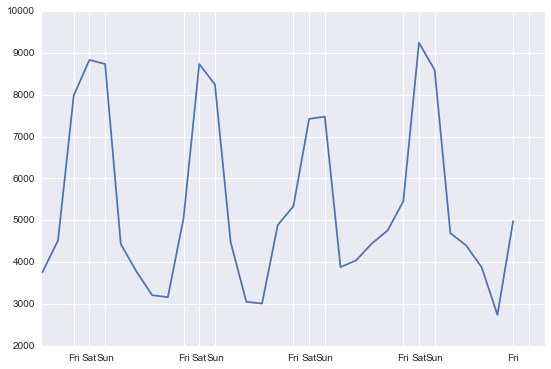

In [31]:
ds = custs[custs.month==7].groupby('date').size().index.to_datetime().map(lambda d: d.dayofweek)
weekends = np.hstack([ds[i:i+3] for i in range(2,len(ds),7)])
wdic = {4:'Fri', 5:'Sat', 6:'Sun'}
plt.figure(figsize=(9,6))
plt.plot(range(len(ds)), custs[custs.month==7].groupby('date').size())
plt.xticks(np.hstack([range(i,i+3) for i in range(2,len(ds),7)]), [wdic[d] for d in weekends])


### Exploring Subscribers

In [116]:
subs = samp[samp.usertype=='Subscriber']
subs.dropna(subset = ['birth year'], inplace = True)
subs.shape

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2816564, 18)

#### How old are subscribers?

In [117]:
subs['age'] = datetime.date.today().year - subs['birth year'].astype('int64')

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [118]:
# this is interesting...
subs[subs.age>80].age.value_counts().sort_index()


81     234
82     202
83     157
84      21
85     152
86       6
87      55
90       5
91      44
92       2
95      46
96       3
97       2
99      17
100      7
104     15
107     72
110      1
116     95
117    576
118    114
121      7
132    233
Name: age, dtype: int64

Some of these must surely be mistakes or subscribers who entered a nonsense year for their birthday, but where do I draw the line on possibility?

For example, here are 2 examples of people riding into their 90s and on!

http://www.bikingbis.com/2010/09/27/never-too-old-to-ride-a-bicycle-extreme-example-is-96-year-old/


https://www.theguardian.com/world/2017/jan/04/105-year-old-man-sets-record-cycling-14-miles-hour-robert-marchand

I'm going to make the cutoff at 90, seems reasonable enough and only losing a miniscule fraction of data.

In [124]:
# less than a 10th of the percentage of data
print "% data over 90 years old:", subs[subs.age>90].shape[0]/float(subs.shape[0])

subs.drop(subs[subs.age>90].index, inplace = True)
subs.shape

% data over 90 years old: 0.00043812247831


/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2815330, 19)

Mean Subscriber Age: 40.4750697076
Median Subscriber Age: 38.0


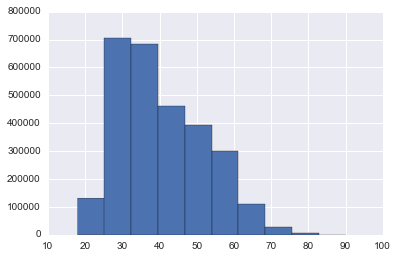

In [125]:
# Citibike popularity dramatically increases and peaks at riders age 30-35
subs.age.hist()
print "Mean Subscriber Age:", subs.age.mean()
print "Median Subscriber Age:", subs.age.median()

#### What is the gender distribution of Subscribers?

In [126]:
# 1 = male, 2 = Female, 0 = Unknown
subs.drop(subs[subs.gender==0].index, inplace = True)
subs.shape

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2812426, 19)

In [127]:
subs.gender.value_counts()
# only 23% of riders are female!
subs.gender.value_counts()[2]/float(len(subs))

0.23036766122913099

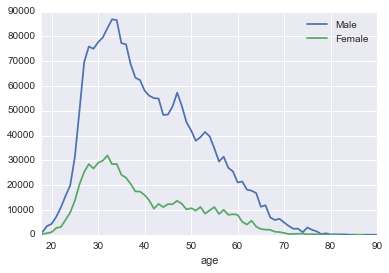

In [128]:
# Rider ages seem to follow a similar pattern for both genders
subs.pivot_table(index = 'age', columns = 'gender', aggfunc='size').plot()
plt.legend(['Male','Female'])


It would seem that overall, women take longer rides (in terms of time on the bike) than men.

This could either mean that they ride further distances, or just ride slower.

<Container object of 10 artists>

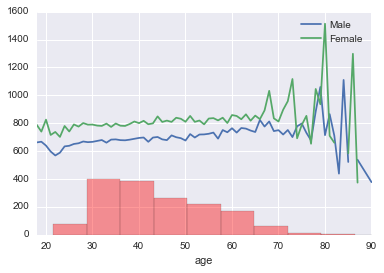

In [220]:
age_gender = subs.pivot_table(index='age',columns = 'gender', values= 'tripduration')
ax = age_gender.plot()
plt.legend(['Male','Female'])
new_min = 0
new_max = 300
new_range = 400

# Distribution of ages amongst the data
c, bins = np.histogram(subs.age)
x = (bins[1:]+bins[:-1])/2
scaled_men = (c- c.min())/float((c.max()-c.min()))*new_range + new_min
plt.bar(x,scaled_men, width = np.diff(x)[0], color='red', alpha = 0.4)

# The noise at the right of the plot is due to low numbers of riders in that age group
# so the mean trip duration of that age group is based on only a few rides.

In the next notebook, I add some geospatial data to look at trip locations. Also I use some additional datasets to explore other angles of the citibike culture.